In [1]:
import matplotlib.pyplot as plt
import numpy as np

import datetime
import pandas_datareader as pdr

import torch
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import import_ipynb
from rbm import RBM

import sys  
sys.path.insert(0, 'C:/Users/dorot/Documents/Thesis/Code/Data')
import modularized_dataeval as eval

importing Jupyter notebook from rbm.ipynb


In [2]:
def train(model, train_loader, n_epochs=20, lr=0.01):
    r"""Train a RBM model.
    Args:
        model: The model.
        train_loader (DataLoader): The data loader.
        n_epochs (int, optional): The number of epochs. Defaults to 20.
        lr (Float, optional): The learning rate. Defaults to 0.01.
    Returns:
        The trained model.
    """
    # optimizer
    train_op = optim.Adam(model.parameters(), lr)

    # train the RBM model
    model.train()

    for epoch in range(n_epochs):
        loss_ = []
        for _, data in enumerate(train_loader):
            v, v_gibbs = model(data.view(-1, 16).float())
            loss = model.free_energy(v) - model.free_energy(v_gibbs)
            loss_.append(loss.item())
            train_op.zero_grad()
            loss.backward()
            train_op.step()

        print('Epoch %d\t Loss=%.4f' % (epoch, np.mean(loss_)))

    return model

In [3]:
# Helper functions for converting between binary numbers and floats
def float_to_bin(float_arr):
    bin_arr = []
    for i in range(len(float_arr)):
        int_version = int(65535*(float_arr[i] - min(float_arr))/(max(float_arr) - min(float_arr)))
        bin_arr.append(format(int_version, "016b"))
    return bin_arr    

def bin_to_float(binary_list, min_float, max_float):
    dec_list = []
    for binary in binary_list:
        dec_list.append(int(binary, 2))
    real_list = []
    for dec in dec_list:
        real_list.append(min_float + dec*(max_float - min_float)/65535)
    return real_list

In [4]:
batch_size = 10 # batch size
n_epochs = 20 # number of epochs
lr = 0.01 # learning rate
n_hid = 12 # number of neurons in the hidden layer
n_vis = 16 # input size

In [5]:
# create a Restricted Boltzmann Machine
model = RBM(n_vis=n_vis, n_hid=n_hid, k=1)

In [6]:
# Read in SP500 data
ticker = "^GSPC"
start=datetime.date(1980, 1, 1)
end=datetime.date(2019, 1, 1)
sp500 = pdr.get_data_yahoo(ticker, start, end)

In [7]:
# Convert to log returns
sp500['Log Return'] = np.log(sp500['Adj Close']) - np.log(sp500['Adj Close'].shift(1))
sp500.dropna(inplace=True)

In [8]:
# Create volatility indicators
# Instead of just doing median, we could do 1st quartile and 3rd quartile (so 4 instead of just 2 categories)
rolling_volatility = sp500['Log Return'].rolling(63).std()  #63 trading days in 3 months
median_volatility = rolling_volatility.median()
volatility_indicator = [1 if rolling_volatility[i] > median_volatility else 0 for i in range(len(rolling_volatility))]
sp500['Volatility Indicator'] = volatility_indicator
sp500_lowvol = sp500.loc[sp500['Volatility Indicator'] == 0]
sp500_highvol = sp500.loc[sp500['Volatility Indicator'] == 1]

In [9]:
# Convert returns to binary numbers
bin_arr_lowvol = float_to_bin(sp500_lowvol['Log Return'].to_numpy())
bin_arr_highvol = float_to_bin(sp500_highvol['Log Return'].to_numpy())

In [10]:
# Convert from array to tensor
bin_tensor_lowvol = torch.from_numpy(np.reshape([int(elem[i]) for elem in bin_arr_lowvol for i in range(len(elem))], (-1,16)))
bin_tensor_highvol = torch.from_numpy(np.reshape([int(elem[i]) for elem in bin_arr_highvol for i in range(len(elem))], (-1,16)))

In [11]:
# Create train loader
train_loader_lowvol = torch.utils.data.DataLoader(bin_tensor_lowvol, batch_size=16)
train_loader_highvol = torch.utils.data.DataLoader(bin_tensor_highvol, batch_size=16)

In [12]:
# Train model
model = RBM(n_vis=n_vis, n_hid=n_hid, k=1)
model_lowvol = train(model, train_loader_lowvol, n_epochs=n_epochs, lr=lr)
model = RBM(n_vis=n_vis, n_hid=n_hid, k=1)
model_highvol = train(model, train_loader_highvol, n_epochs=n_epochs, lr=lr)

Epoch 0	 Loss=0.7639
Epoch 1	 Loss=0.1824
Epoch 2	 Loss=0.0966
Epoch 3	 Loss=0.1026
Epoch 4	 Loss=0.0923
Epoch 5	 Loss=0.0673
Epoch 6	 Loss=0.0607
Epoch 7	 Loss=0.0560
Epoch 8	 Loss=0.0668
Epoch 9	 Loss=0.0510
Epoch 10	 Loss=0.0500
Epoch 11	 Loss=0.0743
Epoch 12	 Loss=0.0734
Epoch 13	 Loss=0.0543
Epoch 14	 Loss=0.0710
Epoch 15	 Loss=0.0754
Epoch 16	 Loss=0.0766
Epoch 17	 Loss=0.0802
Epoch 18	 Loss=0.0815
Epoch 19	 Loss=0.0829
Epoch 0	 Loss=0.9158
Epoch 1	 Loss=0.1819
Epoch 2	 Loss=0.0964
Epoch 3	 Loss=0.0814
Epoch 4	 Loss=0.0470
Epoch 5	 Loss=0.0405
Epoch 6	 Loss=0.0435
Epoch 7	 Loss=0.0352
Epoch 8	 Loss=0.0316
Epoch 9	 Loss=0.0525
Epoch 10	 Loss=0.0368
Epoch 11	 Loss=0.0481
Epoch 12	 Loss=0.0411
Epoch 13	 Loss=0.0397
Epoch 14	 Loss=0.0691
Epoch 15	 Loss=0.0595
Epoch 16	 Loss=0.0517
Epoch 17	 Loss=0.0533
Epoch 18	 Loss=0.0708
Epoch 19	 Loss=0.0471


In [13]:
# Generate new samples, and convert them to a list of binary numbers in string form 
gen_returns_bin_lowvol = []
for elem in train_loader_lowvol:
    v, v_gibbs = model_lowvol(elem.view(-1, 16).float())
    for i in range(len(v_gibbs)):
        gen_returns_bin_lowvol.append(''.join(str(e)[0] for e in v_gibbs[i].tolist()))

gen_returns_bin_highvol = []
for elem in train_loader_highvol:
    v, v_gibbs = model_highvol(elem.view(-1, 16).float())
    for i in range(len(v_gibbs)):
        gen_returns_bin_highvol.append(''.join(str(e)[0] for e in v_gibbs[i].tolist()))

In [14]:
# Convert binary numbers to float (i.e. logreturn)
gen_logreturn_lowvol = np.array(bin_to_float(gen_returns_bin_lowvol, min(sp500_lowvol['Log Return']), max(sp500_lowvol['Log Return'])))
gen_logreturn_highvol = np.array(bin_to_float(gen_returns_bin_highvol, min(sp500_highvol['Log Return']), max(sp500_highvol['Log Return'])))

In [15]:
eval.get_basic_stats(gen_logreturn_highvol)

mean is:  0.0009067773463430297
standard deviation is:  0.015380902830730271
skew is:  -1.6651347693553018
kurtosis is:  27.548090501893633


(0.0009067773463430297,
 0.015380902830730271,
 -1.6651347693553018,
 27.548090501893633)

In [16]:
eval.get_basic_stats(gen_logreturn_lowvol)

mean is:  0.00012266832956610584
standard deviation is:  0.00699240914419347
skew is:  -0.4608384296310023
kurtosis is:  1.9807185732524655


(0.00012266832956610584,
 0.00699240914419347,
 -0.4608384296310023,
 1.9807185732524655)

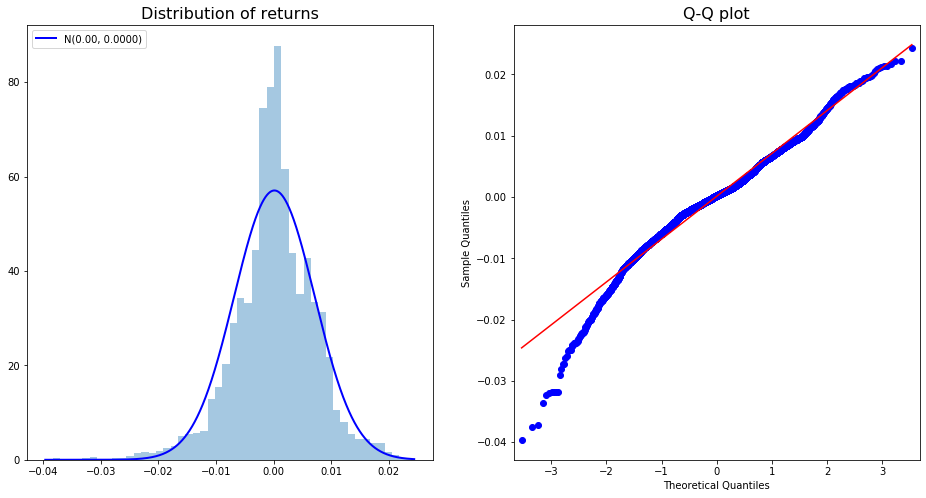

In [17]:
eval.plot_hist_qq(gen_logreturn_lowvol)

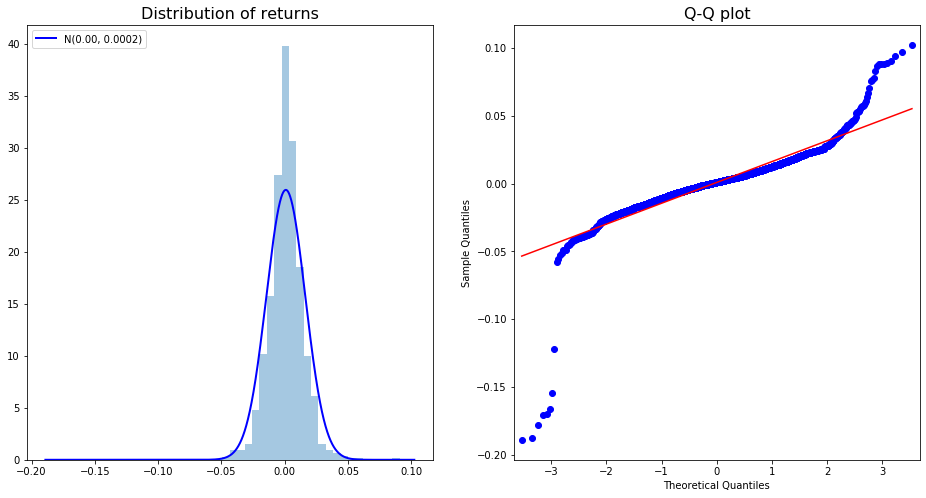

In [18]:
eval.plot_hist_qq(gen_logreturn_highvol)

In [19]:
eval.compute_jarque_bera(gen_logreturn_lowvol)

The Jarque-Bera test statistic value is 983.9787213777865 with probability of 0.0


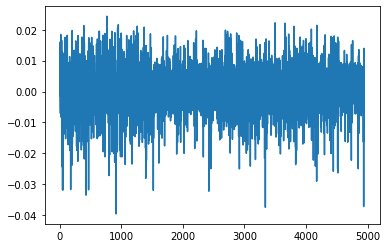

In [20]:
eval.plot_volclusters(gen_logreturn_lowvol)

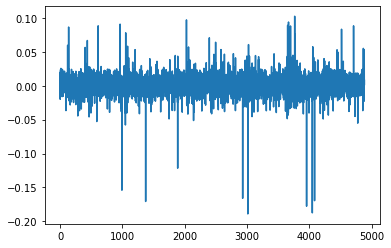

In [21]:
eval.plot_volclusters(gen_logreturn_highvol)

In [28]:
eval.KS_test(sp500_lowvol['Log Return'].to_numpy(), gen_logreturn_lowvol)

Ks_2sampResult(statistic=0.04244139046079224, pvalue=0.0002688596517250054)

In [29]:
eval.KS_test(sp500_highvol['Log Return'].to_numpy(), gen_logreturn_highvol)

Ks_2sampResult(statistic=0.025173966434711422, pvalue=0.0904142914032544)

In [31]:
gen_logreturn = np.concatenate((gen_logreturn_highvol, gen_logreturn_lowvol))

In [33]:
eval.KS_test(gen_logreturn, sp500['Log Return'].to_numpy())

Ks_2sampResult(statistic=0.014948139109212935, pvalue=0.2218907386518913)

In [ ]:
# test w different hyperparameters + number of k-steps
